# Research Analysis Notebook - Updated

This notebook includes graph improvements (organized in tabs), 10 machine learning models with hyperparameter tuning (using 10-fold CV), ensemble techniques, and explainable AI analysis for the best model.


In [7]:
!pip install tensorflow==2.18.0 tensorflow-text==2.18.1 tf-keras==2.18.0
# jupyter nbextension enable --py widgetsnbextension  # Uncomment if running locally

In [8]:
!pip install scikeras

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier # This module is deprecated
from scikeras.wrappers import KerasClassifier # Importing KerasClassifier from scikeras instead

import shap

import ipywidgets as widgets
from IPython.display import display

sns.set(style="whitegrid")
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier #This module is deprecated
from scikeras.wrappers import KerasClassifier # Importing KerasClassifier from scikeras instead


import shap

import ipywidgets as widgets
from IPython.display import display

sns.set(style="whitegrid")
%matplotlib inline

## 1. Data Preprocessing

In [10]:
df = pd.read_excel('Mesothelioma Data Set.xlsx')
print('Dataset dimensions:', df.shape)
print('Missing values per column:')
print(df.isnull().sum())
display(df.head())
print(df.info())

Dataset dimensions: (324, 35)
Missing values per column:
age                                 0
gender                              0
city                                0
asbestos exposure                   0
type of MM                          0
duration of asbestos exposure       0
diagnosis method                    0
keep side                           0
cytology                            0
duration of symptoms                0
dyspnoea                            0
ache on chest                       0
weakness                            0
habit of cigarette                  0
performance status                  0
white blood                         0
cell count (WBC)                    0
hemoglobin (HGB)                    0
platelet count (PLT)                0
sedimentation                       0
blood lactic dehydrogenise (LDH)    0
alkaline phosphatise (ALP)          0
total protein                       0
albumin                             0
glucose                        

,age,gender,city,asbestos exposure,type of MM,duration of asbestos exposure,diagnosis method,keep side,cytology,duration of symptoms,...,pleural lactic dehydrogenise,pleural protein,pleural albumin,pleural glucose,dead or not,pleural effusion,pleural thickness on tomography,pleural level of acidity (pH),C-reactive protein (CRP),class of diagnosis
0,47.0,1,0,1,0.0,20.0,1,0,1,24.0,...,289.0,0.0,0.00,79.0,1,0.0,0.0,0.0,34,1
1,55.0,1,0,1,0.0,45.0,1,0,0,1.0,...,7541.0,1.6,0.80,6.0,1,1.0,1.0,1.0,42,1
2,29.0,1,1,1,0.0,23.0,0,1,0,1.0,...,480.0,0.0,0.00,90.0,1,0.0,0.0,0.0,43,2
3,39.0,1,0,1,0.0,10.0,1,0,0,3.0,...,459.0,5.0,2.80,45.0,1,1.0,0.0,0.0,21,1
4,47.0,1,0,1,0.0,10.0,1,1,1,1.5,...,213.0,3.6,1.95,53.0,1,1.0,0.0,0.0,11,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   age                               324 non-null    float64
 1   gender                            324 non-null    int64  
 2   city                              324 non-null    int64  
 3   asbestos exposure                 324 non-null    int64  
 4   type of MM                        324 non-null    float64
 5   duration of asbestos exposure     324 non-null    float64
 6   diagnosis method                  324 non-null    int64  
 7   keep side                         324 non-null    int64  
 8   cytology                          324 non-null    int64  
 9   duration of symptoms              324 non-null    float64
 10  dyspnoea                          324 non-null    int64  
 11  ache on chest                     324 non-null    int64  
 12  weakness

### 1.1 Data Cleaning and Outlier Removal

In [11]:
continuous_cols = df.select_dtypes(include=['float']).columns

def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

df_clean = df.copy()
for col in continuous_cols:
    df_clean = remove_outliers_iqr(df_clean, col)

print('Original dataset shape:', df.shape)
print('Shape after outlier removal:', df_clean.shape)

Original dataset shape: (324, 35)
Shape after outlier removal: (190, 35)


### 1.2 Feature Engineering

In [12]:
X = df_clean.drop(columns=[df_clean.columns[-1]])
y = df_clean[df_clean.columns[-1]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print('Scaled features sample:')
display(X_scaled.head())

Scaled features sample:


,age,gender,city,asbestos exposure,type of MM,duration of asbestos exposure,diagnosis method,keep side,cytology,duration of symptoms,...,glucose,pleural lactic dehydrogenise,pleural protein,pleural albumin,pleural glucose,dead or not,pleural effusion,pleural thickness on tomography,pleural level of acidity (pH),C-reactive protein (CRP)
0,-1.653205,0.781133,-1.028666,0.389249,0.0,-1.350145,0.621982,-1.369629,-0.573299,-0.712229,...,-0.704372,0.210794,0.684810,0.832669,-0.035854,0.27101,0.0,-1.294626,-1.224745,-1.988669
1,-0.825514,0.781133,-1.028666,0.389249,0.0,-1.350145,0.621982,0.450158,1.744292,-1.269116,...,-1.388228,-1.539211,-0.722696,-0.548698,0.292444,0.27101,0.0,-1.294626,-1.224745,-2.434507
2,-2.273974,0.781133,0.631177,0.389249,0.0,-0.732750,0.621982,-1.369629,1.744292,-0.712229,...,-0.977914,-2.186571,-0.923768,-1.767552,1.195263,0.27101,0.0,-1.294626,-1.224745,-1.453665
3,-0.618591,-1.280191,-0.198744,0.389249,0.0,-0.732750,0.621982,-1.369629,1.744292,-1.083487,...,-0.225672,-1.930473,-0.923768,-1.686295,1.195263,0.27101,0.0,0.772424,-1.224745,-0.026985
4,0.622947,0.781133,-0.198744,0.389249,0.0,-0.732750,0.621982,-1.369629,-0.573299,-0.712229,...,0.800111,1.882548,0.885882,1.157697,-0.692449,0.27101,0.0,0.772424,0.816497,0.508020


In [13]:
stats = df_clean.describe().T
stats['median'] = df_clean.median()
stats['mode'] = df_clean.mode().iloc[0]
stats['skewness'] = df_clean.skew()
stats['kurtosis'] = df_clean.kurtosis()
display(stats)

,count,mean,std,min,25%,50%,75%,max,median,mode,skewness,kurtosis
age,190.0,54.978947,9.690970,25.0,47.00,56.0,61.00,80.0,56.0,56.0,-0.045821,0.106435
gender,190.0,0.621053,0.486407,0.0,0.00,1.0,1.00,1.0,1.0,1.0,-0.503038,-1.765651
city,190.0,2.478947,2.416232,0.0,0.00,2.0,4.00,8.0,2.0,0.0,0.560525,-1.142405
asbestos exposure,190.0,0.868421,0.338926,0.0,1.00,1.0,1.00,1.0,1.0,1.0,-2.197181,2.857576
type of MM,190.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000
duration of asbestos exposure,190.0,31.868421,16.239887,0.0,23.00,35.0,43.00,65.0,35.0,0.0,-0.737182,-0.308457
diagnosis method,190.0,0.721053,0.449666,0.0,0.00,1.0,1.00,1.0,1.0,1.0,-0.993644,-1.023557
keep side,190.0,0.752632,0.550967,0.0,0.00,1.0,1.00,2.0,1.0,1.0,-0.049450,-0.340024
cytology,190.0,0.247368,0.432623,0.0,0.00,0.0,0.00,1.0,0.0,0.0,1.180332,-0.613385
duration of symptoms,190.0,4.918421,2.700662,1.0,3.00,5.0,7.00,12.0,5.0,3.0,0.519553,-0.500485


## 2. Graph Improvements

In [14]:
tab_outlier = widgets.Output()
tab_hist = widgets.Output()
tab_corr = widgets.Output()

with tab_outlier:
    plt.figure(figsize=(18, 12))
    n_cols = 4
    n_rows = int(np.ceil(len(continuous_cols) / n_cols))
    for i, col in enumerate(continuous_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(y=df_clean[col], color='lightblue')
        plt.title(col, fontsize=10)
    plt.tight_layout()
    plt.show()

with tab_hist:
    for col in continuous_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df_clean[col], kde=True, bins=20, color='skyblue')
        plt.title(f'Histogram: {col}')
        plt.tight_layout()
        plt.show()

with tab_corr:
    plt.figure(figsize=(12, 10))
    corr = df_clean[continuous_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix for Continuous Features')
    plt.tight_layout()
    plt.show()
    sns.pairplot(df_clean[continuous_cols[:5]])
    plt.show()

tab = widgets.Tab(children=[tab_outlier, tab_hist, tab_corr])
tab.set_title(0, 'Outlier Detection')
tab.set_title(1, 'Histograms')
tab.set_title(2, 'Correlation')
display(tab)

## 3. Model Building and Evaluation

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def create_nn_model(neurons=64, dropout_rate1=0.3, dropout_rate2=0.2):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate1))
    model.add(Dense(int(neurons / 2), activation='relu'))
    model.add(Dropout(dropout_rate2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models_params = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {'n_estimators': [50, 100, 150], 'max_depth': [None, 5, 10]}
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'param_grid': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'param_grid': {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {'n_neighbors': [3, 5, 7, 9]}
    },
    'NeuralNetwork': {
        'model': KerasClassifier(build_fn=create_nn_model, verbose=0),
        'param_grid': {'epochs': [50, 100], 'batch_size': [16, 32], 'neurons': [64, 128]}
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=42),
        'param_grid': {'n_estimators': [50, 100, 150], 'max_depth': [None, 5, 10]}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'param_grid': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2]}
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'param_grid': {'n_estimators': [50, 100, 150], 'learning_rate': [0.5, 1.0, 1.5]}
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'param_grid': {}
    }
}
print('Defined models:', list(models_params.keys()))

Defined models: ['DecisionTree', 'RandomForest', 'SVM', 'LogisticRegression', 'KNN', 'NeuralNetwork', 'ExtraTrees', 'GradientBoosting', 'AdaBoost', 'GaussianNB']



Tuning and cross-validating DecisionTree...
Best parameters for DecisionTree: {'max_depth': None, 'min_samples_split': 2}


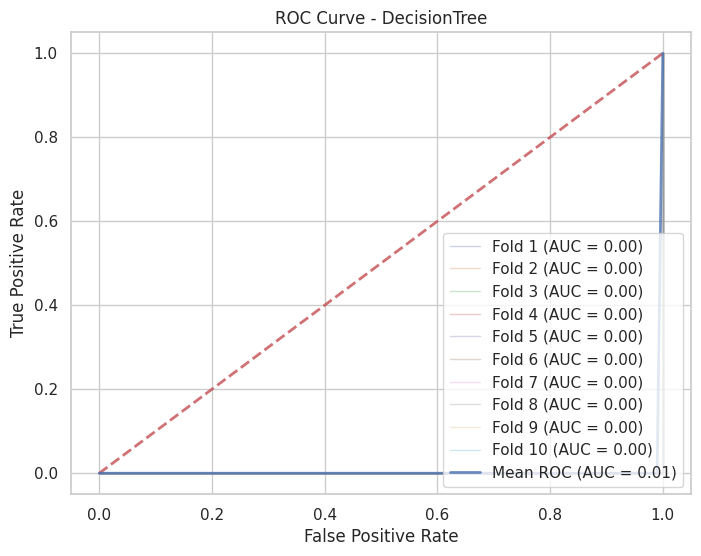

Average metrics for DecisionTree: {'TP': np.float64(4.5), 'FP': np.float64(0.0), 'TN': np.float64(10.7), 'FN': np.float64(0.0), 'Precision': np.float64(1.0), 'Recall': np.float64(1.0), 'F1': np.float64(1.0)}

Tuning and cross-validating RandomForest...
Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 50}


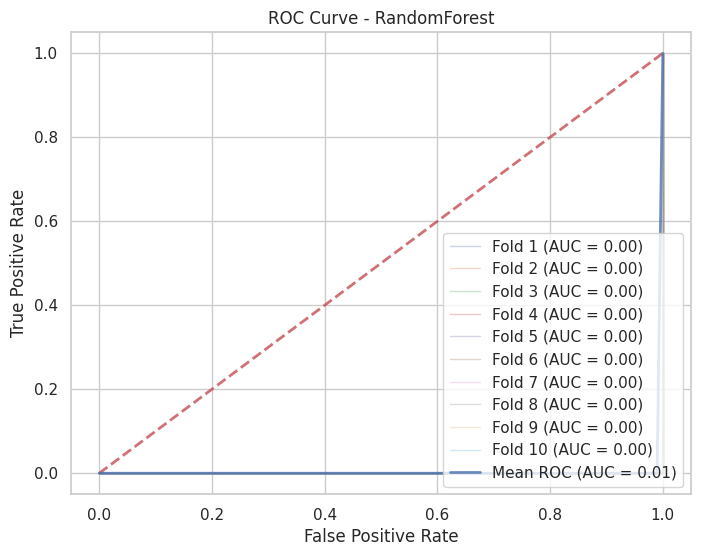

Average metrics for RandomForest: {'TP': np.float64(4.5), 'FP': np.float64(0.0), 'TN': np.float64(10.7), 'FN': np.float64(0.0), 'Precision': np.float64(1.0), 'Recall': np.float64(1.0), 'F1': np.float64(1.0)}

Tuning and cross-validating SVM...
Best parameters for SVM: {'C': 0.1, 'kernel': 'linear'}


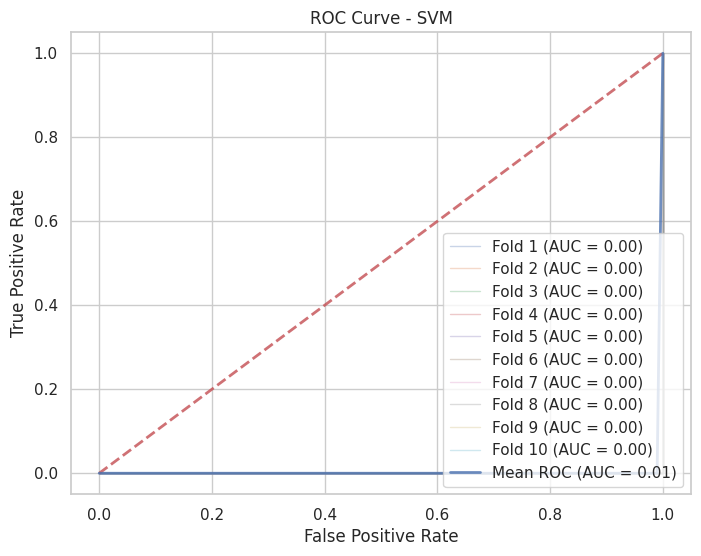

Average metrics for SVM: {'TP': np.float64(4.5), 'FP': np.float64(0.0), 'TN': np.float64(10.7), 'FN': np.float64(0.0), 'Precision': np.float64(1.0), 'Recall': np.float64(1.0), 'F1': np.float64(1.0)}

Tuning and cross-validating LogisticRegression...
Best parameters for LogisticRegression: {'C': 0.1, 'solver': 'lbfgs'}


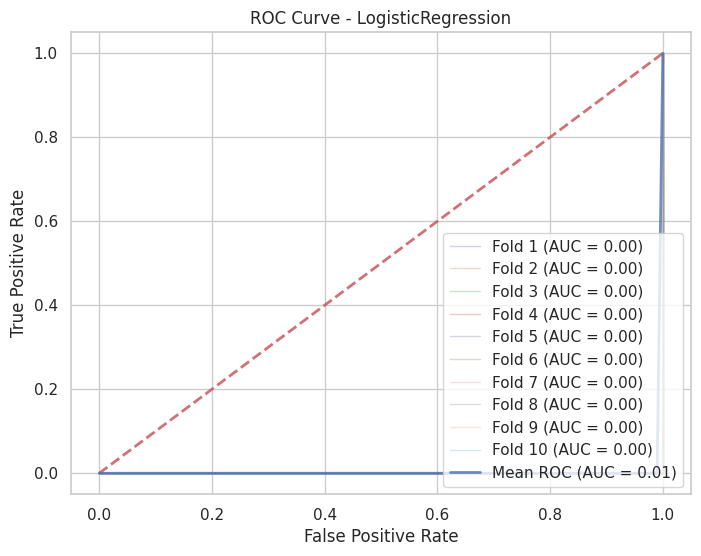

Average metrics for LogisticRegression: {'TP': np.float64(4.5), 'FP': np.float64(0.0), 'TN': np.float64(10.7), 'FN': np.float64(0.0), 'Precision': np.float64(1.0), 'Recall': np.float64(1.0), 'F1': np.float64(1.0)}

Tuning and cross-validating KNN...
Best parameters for KNN: {'n_neighbors': 5}


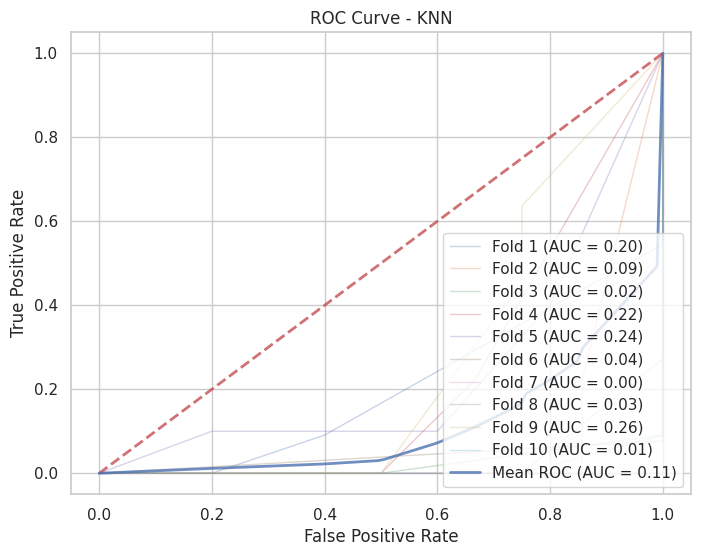

Average metrics for KNN: {'TP': np.float64(2.5), 'FP': np.float64(0.3), 'TN': np.float64(10.4), 'FN': np.float64(2.0), 'Precision': np.float64(0.8966666666666667), 'Recall': np.float64(0.6161904761904762), 'F1': np.float64(0.6788888888888889)}

Tuning and cross-validating NeuralNetwork...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [17]:
!pip install scikeras --upgrade
def compute_metrics(cm):
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN) if (TP + FN) else 0
    FPR = FP / (FP + TN) if (FP + TN) else 0
    precision = TP / (TP + FP) if (TP + FP) else 0
    f1 = 2 * precision * TPR / (precision + TPR) if (precision + TPR) else 0
    return {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN, 'Precision': precision, 'Recall': TPR, 'F1': f1}

best_estimators = {}
model_performance = {}
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

for model_name, mp in models_params.items():
    print(f"\nTuning and cross-validating {model_name}...")
    model = mp['model']
    param_grid = mp['param_grid']
    if param_grid:
        grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
        grid.fit(X_train, y_train)
        best_estimator = grid.best_estimator_
        print(f"Best parameters for {model_name}:", grid.best_params_)
    else:
        best_estimator = model
        best_estimator.fit(X_train, y_train)
        print(f"No hyperparameters to tune for {model_name}.")
    best_estimators[model_name] = best_estimator
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(8, 6))
    for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        best_estimator.fit(X_tr, y_tr)
        y_pred = best_estimator.predict(X_val)
        if hasattr(best_estimator, 'predict_proba'):
            y_prob = best_estimator.predict_proba(X_val)[:, 1]
        elif hasattr(best_estimator, 'decision_function'):
            y_prob = best_estimator.decision_function(X_val)
        else:
            y_prob = y_pred
        cm = confusion_matrix(y_val, y_pred)
        metrics_dict = compute_metrics(cm)
        fold_metrics.append(metrics_dict)
        fpr, tpr, _ = roc_curve(y_val, y_prob, pos_label=1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {fold+1} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    avg_metrics = {k: np.mean([m[k] for m in fold_metrics]) for k in fold_metrics[0]}
    model_performance[model_name] = avg_metrics
    print(f"Average metrics for {model_name}:", avg_metrics)
print("\nAll models evaluated.\n")

In [ ]:
for model_name, metrics_dict in model_performance.items():
    print(f"\nModel: {model_name}")
    print('Average Metrics:', metrics_dict)

In [ ]:
best_model_names = ['RandomForest', 'LogisticRegression', 'SVM']
base_learners = []
for name in best_model_names:
    base_learners.append((name, best_estimators[name]))

stacking_ensemble = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(random_state=42), cv=5)
stacking_ensemble.fit(X_train, y_train)
print('Stacking Ensemble created and fitted.')

from sklearn.ensemble import BaggingClassifier
bagging_ensemble = BaggingClassifier(base_estimator=best_estimators['RandomForest'], n_estimators=10, random_state=42)
bagging_ensemble.fit(X_train, y_train)
print('Bagging Ensemble created and fitted.')

boosting_ensemble = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42), n_estimators=50, random_state=42)
boosting_ensemble.fit(X_train, y_train)
print('Boosting Ensemble created and fitted.')

In [ ]:
rf_final = best_estimators['RandomForest']
rf_final.fit(X_train, y_train)

importances = rf_final.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances (RandomForest)')
plt.bar(range(X_train.shape[1]), importances[indices], align='center', color='teal')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1] if isinstance(shap_values, list) else shap_values, X_train)

## 5. Conclusion and Next Steps

This notebook provided a full pipeline with improved graph visualization, data preprocessing, 10 machine learning models with hyperparameter tuning and 10-fold cross-validation, ensemble techniques, and explainable AI analysis.